## Make detections on individual emergent signals on continuous data in parallel using STA/LTA triggering
- In parallel over days using dask
- Runs on one channel on one station at a time
- NOTE THAT THE 3-10 HZ FILTER IS HARD CODED IN

In [6]:
import datetime
from obspy.clients.fdsn.client import Client
import obspy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
#matplotlib.rcParams['font.family']=['Arial']
client = Client('IRIS')
import pickle
import os
import scipy.signal

In [2]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import trigger_onset

### STA/LTA parameters

In [3]:
# Define sampling rate and step we want to chunk

sr = 200 #in Hz, need to change depending on station
step = 10 # seconds

# Define sta and lta window lengths
# Below chosen to optimize emergent signal detection!
sta_win = 10 # seconds, short term window
lta_win = 1000 # seconds, long term window

### Time endpoints and station

In [4]:
t1 = obspy.UTCDateTime("2017-09-01T00:00:00.000")
t2 = obspy.UTCDateTime("2017-09-08T00:00:00.000")

network = 'OO'
station = 'HYS14'
channel = 'HHN'

### Define functions

In [7]:
def check_data(stream,t1,sr,step,data_time_length):
    
    data = stream[0].data
    data_sample_length = sr * data_time_length

    
    # Catch for if data stream is less than specified
    if len(data) < data_sample_length:
        data_sample_length = int(len(data) - (len(data)%(sr*step)))
        data_time_length = int(data_sample_length / sr)
        
    # Catch for if start time is not as specified
    if stream[0].stats.starttime != t1:
        t1 = stream[0].stats.starttime
    
    return(t1,data_time_length)

In [7]:
def calc_stalta(data,sr,step,data_time_length,sta_win,lta_win):
    
    # Matricize the data as step s chunks
    data_sample_length = sr * data_time_length
    
    
    chunked = np.reshape(data[0:data_sample_length],[int(data_sample_length/(sr*step)),int(sr*step)])
    chunked_medians = [np.median(chunked[i,:]) for i in range(np.shape(chunked)[0])]
    chunked_times = np.linspace(0,data_time_length,len(chunked_medians))
    
    # Step through and calculate sta & lta every step s
    sta = []
    lta = []
    for i,vec in enumerate(chunked_medians):

        # STA is median of the next window
        nwin = int(sta_win / step)
        sta.append(np.median(chunked_medians[i:i+nwin]))


        # LTA is median of the past window
        nwin = int(lta_win / step)
        lta.append(np.median(chunked_medians[i-nwin:i]))
    
    stalta = np.array(sta)/np.array(lta)
    
    return(stalta,chunked_times)

In [9]:
def trigger(t1, data_time_length, network, station, channel, sr, step, sta_win, lta_win):
    """
    t1 = start of time period to process, UTCDateTime
    data_time_length = overall length of time period, in seconds
    network = network code of desired station, string
    station = station code, string
    channel = channel code, string
    sr = sampling rate of desired channel
    step = duration of length of time to step through data with (speeds up processing), seconds
    sta_win = duration of short-term window, seconds
    lta_win = duration of long-term window, seconds
    
    Outputs:
    ontimes = list of on-times of all detection windows
    offtimes = list of off-times of all detection windows
    """
    t2 = t1 + data_time_length + 1000 # signals at the end
    t1 = t1 - 1000 # signals at the beginning

    # Pull in data
    try:
        st1 = client.get_waveforms(network, station, "*", channel, t1 - 5, t2 + 5)
        st1.resample(sr).merge(fill_value=0)
        st1.taper(0.05, max_length=5)
        st1.filter('bandpass', freqmin=3, freqmax=10)
        st1.trim(starttime=t1, endtime=t2)

        # Check to make sure there is data whole time period of t1 + data_time_length
        # If not, adjust some values to reflect that
        t1, data_time_length = check_data(st1, t1, sr, step, data_time_length)

        # Run STA/LTA triggering
        data = np.abs(st1[0].data)
        stalta, times = calc_stalta(data, sr, step, data_time_length, sta_win, lta_win)
       
        # get triggers and the seconds they correspond to
        triggers = trigger_onset(stalta, 2, 1)
        ons = [times[tr[0]] for tr in triggers]
        offs = [times[tr[1]] for tr in triggers]
        
        # get start and stop times of windows
        ontimes = [t1 + o for o in ons]
        offtimes = [t1 + o for o in offs]

        return(ontimes, offtimes)
    
    except:
        print(['No data for', str(t1)])
        return([])

    # Classification

    pad = 0
    t1 = t[0] - pad
    t2 = t[1] + pad

    st1 = client.get_waveforms(network, station, "*", channel, t1 - 5, t2 + 5, attach_response=True)
    st1.resample(sr).merge(fill_value='interpolate')
    st1[0].data /= st1[0].stats.response.instrument_sensitivity.value
    st1.trim(starttime=t1, endtime=t2)
    ship_classifier = ship_noise_classifier(st1[0], sr)

    st1 = client.get_waveforms(network, station, "*", channel, t1 - 5, t2 + 5, attach_response=True)
    st1.resample(sr).merge(fill_value='interpolate')
    st1.filter('bandpass', freqmin=3, freqmax=10)
    st1.remove_response()
    st1.trim(starttime=t1, endtime=t2)

    max_amplitude = np.max(np.abs(st1[0].data))
    smoothed_window = apply_gaussian(st1[0].data, sr, gaussian_width=15)
    smoothed_window /= np.max(smoothed_window)
    peaks, _ = scipy.signal.find_peaks(smoothed_window, prominence=0.1)
    num_waveform_peaks = len(peaks)

    # Frequency Ratio
    pad = 30
    t1 = t[0] - pad
    t2 = t[1] + pad
    st2 = client.get_waveforms(network, station, "*", channel, t1 - 5, t2 + 5, attach_response=True)
    st2.resample(sr).merge(fill_value='interpolate')
    st2[0].data /= st2[0].stats.response.instrument_sensitivity.value
    st2.trim(starttime=t1, endtime=t2)
    f, Pxx_den, peak_ind, peak_details, median_power = pick_peaks_welch(st2[0], sr, 5, microseism_cutoff=False)
    freq_ratio = 10**(np.median(Pxx_den[25:50])/10) / 10**(np.median(Pxx_den[50:75])/10)
    freq_ratio_welch = freq_ratio

    # Save results
    with open(file_name, 'wb') as handle:
        pickle.dump([t, station, num_waveform_peaks, ship_classifier, freq_ratio_welch, max_amplitude], handle)

    return ontimes, offtimes, t, station, num_waveform_peaks, ship_classifier, freq_ratio_welch, max_amplitude

finally Exception as e:
    print(['No data for', str(t1), 'Error:', str(e)])
    return []


SyntaxError: invalid syntax (3130168069.py, line 93)

### Bin data by days and process in parallel

In [8]:
time_bins = pd.date_range(start=t1.datetime, end=t2.datetime, freq='d')
data_time_length = 24 * 60 * 60

In [9]:
time_bins

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08'],
              dtype='datetime64[ns]', freq='D')

In [10]:
@dask.delayed
def loop_days(t1,data_time_length,network,station,channel,sr,step,sta_win,lta_win):
    t1 = obspy.UTCDateTime(t1)
    return trigger(t1,data_time_length,network,station,channel,sr,step,sta_win,lta_win)

In [11]:
lazy_results = [loop_days(t,data_time_length,network,station,channel,sr,step,sta_win,lta_win) for t in time_bins]

In [12]:
with ProgressBar():
    results = dask.compute(lazy_results)

[                                        ] | 0% Completed | 14.90 sms

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 15.42 s

/tmp/ipykernel_3885241/1058069781.py:25: RuntimeWarning: overflow encountered in divide
  stalta = np.array(sta)/np.array(lta)


[                                        ] | 0% Completed | 18.78 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 24.50 s['No data for', '2017-09-08T00:27:40.307906Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[#####                                   ] | 12% Completed | 25.11 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[#####                                   ] | 12% Completed | 32.92 s['No data for', '2017-09-07T00:27:20.305591Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[##########                              ] | 25% Completed | 33.83 s['No data for', '2017-09-05T00:09:20.180576Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[###############                         ] | 37% Completed | 34.34 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[###############                         ] | 37% Completed | 35.56 s['No data for', '2017-09-02T00:20:10.255817Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[####################                    ] | 50% Completed | 39.91 s['No data for', '2017-09-03T00:20:10.255817Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[#########################               ] | 62% Completed | 43.34 s['No data for', '2017-09-01T00:23:40.280125Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[##############################          ] | 75% Completed | 51.61 s['No data for', '2017-09-04T00:18:20.243084Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[###################################     ] | 87% Completed | 51.92 s['No data for', '2017-09-06T01:37:00.789443Z', 'Error:', "name 'ship_noise_classifier' is not defined"]
[########################################] | 100% Completed | 52.02 s


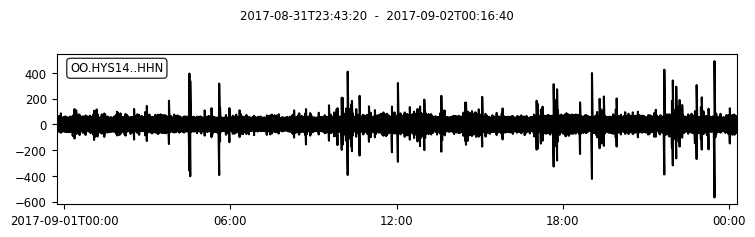

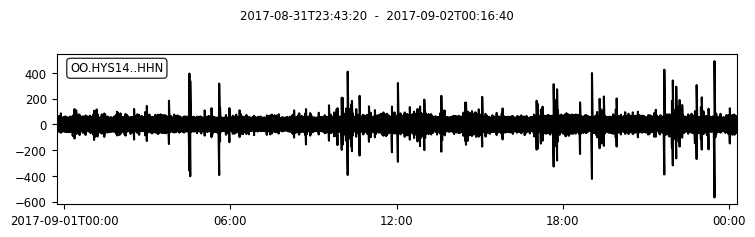

In [13]:
t2 = t1 + data_time_length + 1000
t1 = t1 - 1000

# Pull in data
st1 = client.get_waveforms(network, station, "*", channel, t1 - 5, t2 + 5)
st1.resample(sr).merge(fill_value=0)
st1.taper(0.05, max_length=5)
st1.filter('bandpass', freqmin=3, freqmax=10)
st1.trim(starttime=t1, endtime=t2)



st1.plot()


/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


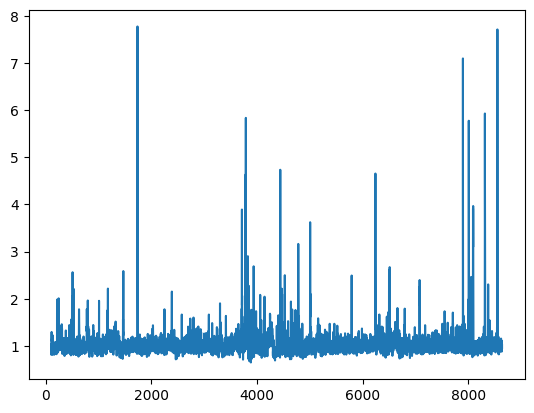

In [14]:
data = np.abs(st1[0].data)

stalta = calc_stalta(data,sr,step,data_time_length,sta_win,lta_win)
plt.plot(stalta[0])



### Concat results and save

In [15]:
save_dir='emergent_detections/'
pickle_name='HYS14_sep2017_HHN.pickle'
ons = []
offs = []
for ap in results[0]:
    if len(ap) > 0:
        ons.extend(ap[0])
        offs.extend(ap[1])
sort_ind = np.argsort(ons)
ons = [ons[i] for i in sort_ind]
offs = [offs[i] for i in sort_ind]
triggers = [[ons[i],offs[i]] for i in range(len(ons))]


# Toss any with durations less than 30 s
durations = [t[1]-t[0] for t in triggers]
dur_keep = [i for i,e in enumerate(durations) if e >= 30]
triggers = [triggers[i] for i in dur_keep]


pickle.dump(triggers,open(pickle_name, 'wb'))

In [16]:
len(triggers)

0